In [1]:
# Cell 1: Imports

import os
import numpy as np
import pandas as pd

from skimage.transform import resize
from skimage.io import imread

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

sns.set()
RANDOM_STATE = 42


In [2]:
target = []
images = []   # In matrix format
flat_data = []  # In vector format

datadir = '../Data/AppleData'
categories = ['Apple___Apple_scab',
              'Apple___Black_rot',
              'Apple___Cedar_apple_rust',
              'Apple___healthy',
              'Background_without_leaves']

for category in categories:
  path= datadir + '/' + category
  for img in os.listdir(path):
    img_matrix=imread(os.path.join(path,img))
    img_resized=resize(img_matrix,(150,150,3))
    flat_data.append(img_resized.flatten())
    images.append(img_resized)
    target.append(category)

In [3]:
import pandas as pd
df=pd.DataFrame(flat_data)
df['Target']=target

In [4]:
# Cell 3: Train/test split only (no scaling or PCA here)

from sklearn.model_selection import train_test_split

# Separate features and labels
X = df.drop(columns=["Target"]).values.astype("float32")
y = df["Target"].values

# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Raw X_train shape:", X_train_raw.shape)
print("Raw X_test shape:", X_test_raw.shape)
print("Train label counts:")
print(pd.Series(y_train).value_counts())


Raw X_train shape: (4630, 67500)
Raw X_test shape: (1158, 67500)
Train label counts:
Apple___healthy              1316
Background_without_leaves     914
Apple___Apple_scab            800
Apple___Cedar_apple_rust      800
Apple___Black_rot             800
Name: count, dtype: int64


In [ ]:
# Cell 4: Pipeline (Scaler + PCA + Random Forest) with RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=RANDOM_STATE)),
    ("rf", RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

param_dist_rf = {
    # Let CV find the best PCA dimension
    "pca__n_components": [200, 300, 400, 500, 700, 1000],

    # RF hyperparameters
    "rf__n_estimators": [400, 800, 1200, 1600],
    "rf__max_depth": [None, 30, 50, 80],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", 0.2, 0.4],
    "rf__bootstrap": [True],
    "rf__criterion": ["gini", "entropy"],
}

rf_search = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=80,               # can bump to 100+ if runtime is fine
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)

rf_search.fit(X_train_raw, y_train)

print("Best RF pipeline CV accuracy:", rf_search.best_score_)
print("Best RF pipeline params:", rf_search.best_params_)

best_rf_pipeline = rf_search.best_estimator_


Fitting 5 folds for each of 80 candidates, totalling 400 fits


Random Forest Pipeline Test Accuracy: 0.8558

Classification Report:
                           precision    recall  f1-score   support

       Apple___Apple_scab       0.86      0.67      0.75       200
        Apple___Black_rot       0.87      0.81      0.83       200
 Apple___Cedar_apple_rust       0.86      0.93      0.89       200
          Apple___healthy       0.81      0.91      0.86       329
Background_without_leaves       0.91      0.93      0.92       229

                 accuracy                           0.86      1158
                macro avg       0.86      0.85      0.85      1158
             weighted avg       0.86      0.86      0.85      1158



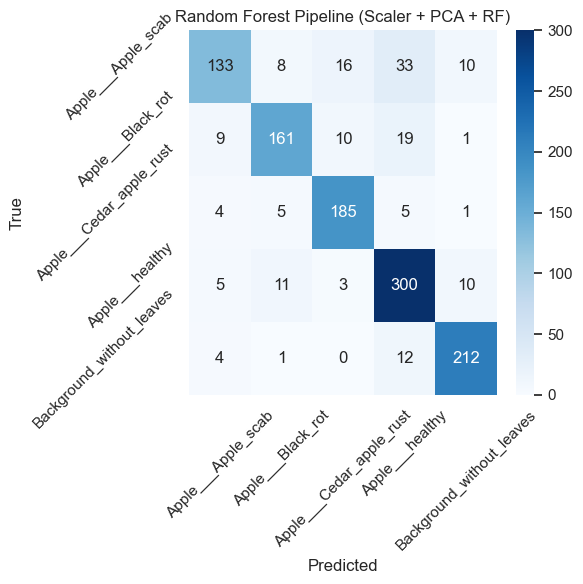

In [6]:
# Cell 5: Evaluate Random Forest pipeline on test set

y_pred = best_rf_pipeline.predict(X_test_raw)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Pipeline Test Accuracy: {test_accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=categories)
cm_df = pd.DataFrame(cm, index=categories, columns=categories)

plt.figure(figsize=(6, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Pipeline (Scaler + PCA + RF)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# Cell 6: CV results table for Decision Tree

cv_results = pd.DataFrame(rand_search.cv_results_)
cv_results_sorted = cv_results.sort_values("mean_test_score", ascending=False)

cv_results_sorted[[
    "mean_test_score",
    "std_test_score",
    "param_max_depth",
    "param_min_samples_split",
    "param_min_samples_leaf"
]].head(10)


NameError: name 'rand_search' is not defined

In [ ]:
# Cell 7: CV results table for Decision Tree

cv_results = pd.DataFrame(rand_search.cv_results_)
cv_results_sorted = cv_results.sort_values("mean_test_score", ascending=False)

cv_results_sorted[[
    "mean_test_score",
    "std_test_score",
    "param_max_depth",
    "param_min_samples_split",
    "param_min_samples_leaf"
]].head(10)


In [ ]:
# Cell 8: Confusion matrix plot

plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Decision Tree Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Cell 9: Tree complexity and feature importances

print("Tree depth:", best_dt.get_depth())
print("Number of leaves:", best_dt.get_n_leaves())

importances = best_dt.feature_importances_
nonzero_importances = importances[importances > 0]

print("Non-zero feature count:", len(nonzero_importances))

# Show top 20
top_idx = np.argsort(importances)[-20:][::-1]
top_vals = importances[top_idx]

pd.DataFrame({
    "feature_index": top_idx,
    "importance": top_vals
})


[CV] END pca__n_components=1000, rf__bootstrap=True, rf__criterion=entropy, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=400; total time= 2.7min
[CV] END pca__n_components=1000, rf__bootstrap=True, rf__criterion=gini, rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=1200; total time= 4.5min

[CV] END pca__n_components=400, rf__bootstrap=True, rf__criterion=gini, rf__max_depth=30, rf__max_features=0.2, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=1200; total time= 8.9min
[CV] END pca__n_components=500, rf__bootstrap=True, rf__criterion=entropy, rf__max_depth=30, rf__max_features=0.4, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=1600; total time=36.8min
[CV] END pca__n_components=1000, rf__bootstrap=True, rf__criterion=entropy, rf__max_depth=50, rf__max_features=0.2, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_esti